# Cap 6415 - Computer Vision – Fall 2025
### Author: Lawrence A Egharevba        (Z23814966)

# Project Topic: Input Image Feature Reconstruction from Deep Networks
**Project Overview**

This project investigates deep image reconstruction from intermediate neural features using a modular feature extraction and decoding pipeline.  
Leveraging a pretrained **ResNet-50** model, multi-layer activations are captured via forward hooks and processed through custom utilities to enable both strict per-layer and concatenated feature analyses.  
Convolutional decoder networks are trained and evaluated on these features to reconstruct original images.  
Metrics (**MSE, PSNR, SSIM**) and visualizations assess reconstruction fidelity, showing clear gradients in quality across feature depths and decoder architectures.


##1. Install & Import Modules

- torch, torch.nn: Core libraries for building and training neural networks.

- torch.utils.data.DataLoader: Efficient batching and loading of datasets.

- torchvision.datasets, transforms, models: Tools for datasets, preprocessing, and pretrained models.

- matplotlib.pyplot: Visualization of images and plots.

- numpy: Array and metric calculations.

- skimage.metrics: Computes image quality metrics (PSNR, SSIM) for reconstruction evaluation.

These imports together enable dataset preparation, model setup, network training, image reconstruction, and both qualitative and quantitative evaluation in your deep learning workflow.


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


I used `from google.colab import drive and drive.mount('/content/drive')` to connect my Colab notebook to Google Drive. This allowed me to easily save and access files, datasets, model checkpoints, and results directly between the notebook and cloud storage, simplifying data transfer and sharing—especially given the large dataset size.

Uploading the ILSVRC2012 validation set (~6GB) was challenging due to a slow and unstable internet connection. To address this, I split the .tar archive into smaller chunks on my PC/Mac with:

split -b 2000M ILSVRC2012_img_val.tar part_

I then uploaded each part_* file to Google Drive and merged them in Colab, enabling efficient handling of large files.


In [2]:
from google.colab import drive
drive.mount('/content/drive') #


Mounted at /content/drive


Navigate to the part files in Google Drive, then reassemble and recombined them in Colab:

In [3]:
# For example, if your files are in /content/drive/MyDrive/
!cat /content/drive/MyDrive/part_* > /content/ILSVRC2012_img_val.tar


Check and Extract the Recombined File:


In [4]:
!ls -lh /content/ILSVRC2012_img_val.tar  # Should be ~6GB

# Extract the tar archive to target folder
!mkdir -p /content/ILSVRC2012_img_val
!tar -xvf /content/ILSVRC2012_img_val.tar -C /content/ILSVRC2012_img_val/


Streaming output truncated to the last 5000 lines.
ILSVRC2012_val_00049867.JPEG
ILSVRC2012_val_00049494.JPEG
ILSVRC2012_val_00048672.JPEG
ILSVRC2012_val_00048308.JPEG
ILSVRC2012_val_00047912.JPEG
ILSVRC2012_val_00045841.JPEG
ILSVRC2012_val_00044931.JPEG
ILSVRC2012_val_00044439.JPEG
ILSVRC2012_val_00043527.JPEG
ILSVRC2012_val_00042653.JPEG
ILSVRC2012_val_00042377.JPEG
ILSVRC2012_val_00041405.JPEG
ILSVRC2012_val_00040366.JPEG
ILSVRC2012_val_00035524.JPEG
ILSVRC2012_val_00033710.JPEG
ILSVRC2012_val_00031038.JPEG
ILSVRC2012_val_00030167.JPEG
ILSVRC2012_val_00024859.JPEG
ILSVRC2012_val_00024401.JPEG
ILSVRC2012_val_00023858.JPEG
ILSVRC2012_val_00023793.JPEG
ILSVRC2012_val_00022999.JPEG
ILSVRC2012_val_00021691.JPEG
ILSVRC2012_val_00021616.JPEG
ILSVRC2012_val_00020289.JPEG
ILSVRC2012_val_00019766.JPEG
ILSVRC2012_val_00019701.JPEG
ILSVRC2012_val_00017988.JPEG
ILSVRC2012_val_00017438.JPEG
ILSVRC2012_val_00015230.JPEG
ILSVRC2012_val_00014799.JPEG
ILSVRC2012_val_00014292.JPEG
ILSVRC2012_val_000125

This file is required to map each validation image to its correct class, as the validation images are not already organized by class. Select and upload ILSVRC2012_validation_ground_truth.txt

In [5]:
from google.colab import files
files.upload(). # Upload ILSVRC2012_validation_ground_truth.txt


Saving ILSVRC2012_validation_ground_truth.txt to ILSVRC2012_validation_ground_truth.txt


{'ILSVRC2012_validation_ground_truth.txt': b'490\n361\n171\n822\n297\n482\n13\n704\n599\n164\n649\n11\n73\n286\n554\n6\n648\n399\n749\n545\n13\n204\n318\n693\n399\n304\n102\n207\n480\n780\n644\n275\n14\n954\n249\n790\n501\n547\n809\n606\n297\n927\n424\n156\n60\n983\n256\n207\n281\n456\n413\n498\n561\n750\n182\n267\n118\n893\n597\n840\n836\n107\n647\n471\n945\n451\n214\n790\n291\n837\n707\n193\n397\n568\n401\n705\n200\n202\n31\n949\n361\n98\n709\n483\n563\n695\n122\n497\n914\n476\n102\n199\n104\n221\n138\n257\n188\n436\n229\n52\n377\n200\n597\n544\n131\n935\n602\n342\n508\n748\n617\n901\n184\n513\n204\n999\n782\n922\n869\n598\n596\n701\n970\n452\n631\n817\n57\n398\n885\n10\n288\n305\n34\n112\n273\n120\n959\n657\n823\n356\n32\n657\n753\n372\n364\n349\n106\n513\n551\n366\n228\n917\n464\n655\n737\n58\n62\n219\n832\n922\n192\n303\n946\n996\n737\n333\n729\n824\n517\n89\n724\n2\n829\n172\n266\n123\n434\n149\n39\n171\n44\n662\n734\n782\n270\n153\n283\n58\n217\n581\n170\n306\n689\n753\n613\n454

Then run the script to organize images by class. Once this script finishes, the /content/ILSVRC2012_val_foldered/ will be populated with class-numbered folders, each containing images.

In [6]:
import os, shutil
img_dir = '/content/ILSVRC2012_img_val'
gt_file = '/content/ILSVRC2012_validation_ground_truth.txt'
out_dir = '/content/ILSVRC2012_val_foldered'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
with open(gt_file, 'r') as f:
    labels = [int(line.strip()) for line in f.readlines()]
for idx, label in enumerate(labels):
    imgname = f'ILSVRC2012_val_{idx+1:08d}.JPEG'
    src = os.path.join(img_dir, imgname)
    class_folder = os.path.join(out_dir, str(label))
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)
    shutil.move(src, os.path.join(class_folder, imgname))
print("Organization complete!")


Organization complete!


##2. Data Loading.
Loads and preprocesses image data into batches for efficient training and evaluation of the reconstruction model

In [7]:
# Path to class-organized validation folder
data_dir = '/content/ILSVRC2012_val_foldered'

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(root=data_dir, transform=preprocess)
loader = DataLoader(dataset, batch_size=8, shuffle=True)


##3. Load Pretrained ResNet50 & Register Feature Hooks.
Initializes a pretrained ResNet50 model and sets up hooks to extract intermediate feature maps from selected layers during forward passes.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models import ResNet50_Weights

resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
resnet50.eval()

# Define hook layers (from early, mid, deep, deepest)
layer_names = ["layer1.2.relu", "layer2.3.relu", "layer3.5.relu", "layer4.2.relu"]

class FeatureExtractor(nn.Module):
    def __init__(self, model, layer_names):
        super().__init__()
        self.model = model
        self.layers = layer_names
        self._outputs = {}
        self._register_hooks()
    def _register_hooks(self):
        for name in self.layers:
            layer = dict(self.model.named_modules())[name]
            layer.register_forward_hook(self._make_hook(name))
    def _make_hook(self, name):
        def hook(module, input, output):
            self._outputs[name] = output
        return hook
    def forward(self, x):
        self._outputs = {}
        _ = self.model(x)
        # Output list in specified layer order
        return [self._outputs[name] for name in self.layers]

extractor = FeatureExtractor(resnet50, layer_names)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]


##4. Prepare Concatenated Features (Resize and Concat Tensors)
Resizes feature maps to a common spatial size and concatenates them along the channel dimension to form a unified decoder input tensor.

In [9]:
def extract_and_concat_features(images, extractor):
    with torch.no_grad():
        feats = extractor(images)
        # Use deepest layer spatial size as reference for upsampling
        spatial_size = feats[-1].shape[2:]
        up_feats = [F.interpolate(f, size=spatial_size, mode='bilinear') for f in feats]
        feat_cat = torch.cat(up_feats, dim=1)
    return feat_cat  # (batch, total_channels, H, W)


##5. Memory-Efficient All-Conv Decoder
Implements a decoder network using only convolutional and transposed convolution layers to upsample concatenated features efficiently, minimizing memory usage during reconstruction.

In [10]:
class ConvOnlyDecoder(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_ch, 512, 4, stride=2, padding=1),   # 7x7 -> 14x14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),     # 14x14 -> 28x28
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),     # 28x28 -> 56x56
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),      # 56x56 -> 112x112
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),        # 112x112 -> 224x224
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.up(x)


##6. Instantiate the Decoder (Get in_ch)
Creates the decoder model with the input channel size set to match the concatenated feature tensor, ensuring proper alignment for reconstruction.

In [11]:
# Get a batch and example features
images, labels = next(iter(loader))
images = images.to(device)
feat_cat = extract_and_concat_features(images, extractor)
in_ch = feat_cat.shape[1]

decoder = ConvOnlyDecoder(in_ch).to(device)


##7. Training Loop
Iteratively updates the decoder’s weights using batches of features and images, minimizing reconstruction error over multiple epochs with gradient descent

In [12]:
import torch.optim as optim

decoder.train()
optimizer = optim.Adam(decoder.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 32
for epoch in range(epochs):
    running_loss = 0.0
    for images, _ in loader:
        images = images.to(device)
        feat_cat = extract_and_concat_features(images, extractor)
        recon = decoder(feat_cat)
        loss = loss_fn(recon, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    avg_loss = running_loss / len(loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} - Avg Train Loss: {avg_loss:.4f}")


Epoch 1/32 - Avg Train Loss: 0.9747
Epoch 2/32 - Avg Train Loss: 0.9129
Epoch 3/32 - Avg Train Loss: 0.9048
Epoch 4/32 - Avg Train Loss: 0.9006
Epoch 5/32 - Avg Train Loss: 0.8978
Epoch 6/32 - Avg Train Loss: 0.8958
Epoch 7/32 - Avg Train Loss: 0.8943
Epoch 8/32 - Avg Train Loss: 0.8931
Epoch 9/32 - Avg Train Loss: 0.8920
Epoch 10/32 - Avg Train Loss: 0.8912
Epoch 11/32 - Avg Train Loss: 0.8905
Epoch 12/32 - Avg Train Loss: 0.8898
Epoch 13/32 - Avg Train Loss: 0.8893
Epoch 14/32 - Avg Train Loss: 0.8888
Epoch 15/32 - Avg Train Loss: 0.8883
Epoch 16/32 - Avg Train Loss: 0.8880
Epoch 17/32 - Avg Train Loss: 0.8876
Epoch 18/32 - Avg Train Loss: 0.8872
Epoch 19/32 - Avg Train Loss: 0.8869
Epoch 20/32 - Avg Train Loss: 0.8867
Epoch 21/32 - Avg Train Loss: 0.8864
Epoch 22/32 - Avg Train Loss: 0.8861
Epoch 23/32 - Avg Train Loss: 0.8859
Epoch 24/32 - Avg Train Loss: 0.8857
Epoch 25/32 - Avg Train Loss: 0.8854
Epoch 26/32 - Avg Train Loss: 0.8852
Epoch 27/32 - Avg Train Loss: 0.8850
Epoch 28/3

##8. Visualization and Metrics.
Displays original and reconstructed images side by side and computes quantitative metrics (MSE, PSNR, SSIM) to assess reconstruction quality.

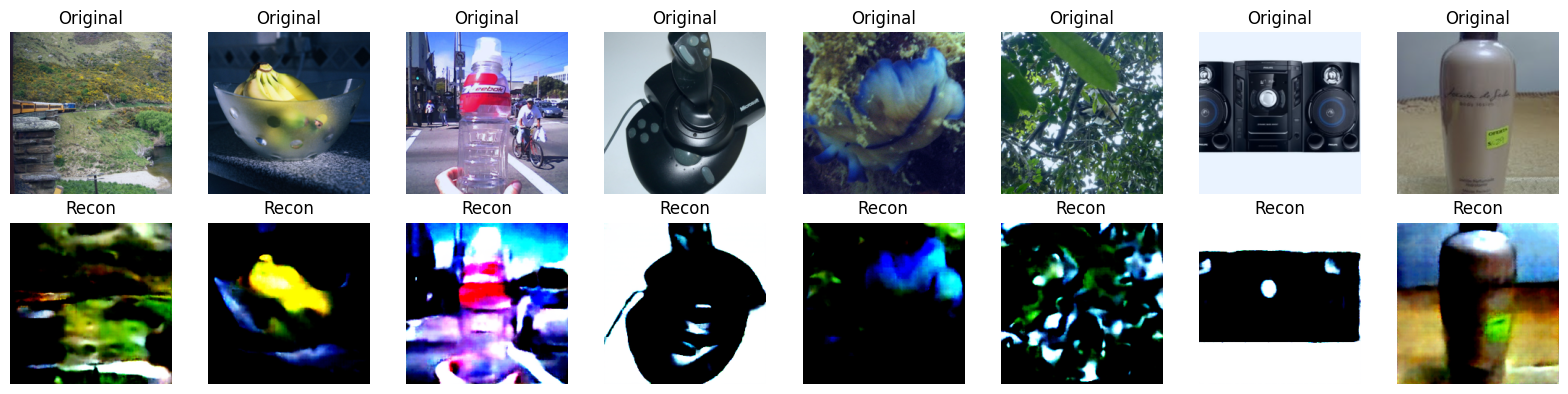

MSE: 1.0028 | PSNR: 1.25 | SSIM: 0.1511


In [13]:
decoder.eval()
with torch.no_grad():
    feat_cat = extract_and_concat_features(images, extractor)
    recon = decoder(feat_cat)

plt.figure(figsize=(16, 4))
for i in range(min(images.shape[0], 8)):
    plt.subplot(2, 8, i+1)
    img = images[i].detach().cpu().permute(1,2,0).numpy()
    img = (img - img.min())/(img.max() - img.min())
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')
    plt.subplot(2, 8, i+9)
    rimg = recon[i].detach().cpu().permute(1,2,0).numpy()
    plt.imshow(rimg)
    plt.title("Recon")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Metrics
orig = images.cpu().detach().numpy()
reco = recon.cpu().detach().numpy()
mse = np.mean((orig - reco) ** 2)
psnr = np.mean([peak_signal_noise_ratio(o, r, data_range=1.0) for o, r in zip(orig, reco)])
ssim = np.mean([structural_similarity(np.transpose(o, (1,2,0)), np.transpose(r, (1,2,0)), win_size=11, data_range=1.0, channel_axis=2) for o, r in zip(orig, reco)])
print(f"MSE: {mse:.4f} | PSNR: {psnr:.2f} | SSIM: {ssim:.4f}")


##9. Save_model.
Stores the trained decoder’s weights to disk, enabling easy reuse, future evaluation, or sharing of the reconstruction model.

In [14]:
import torch
import os

# Use your actual variable names: decoder (model), optimizer, last epoch, last loss
save_dir = "/content/checkpoints"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "decoder_final.pth")

torch.save({
    'epoch': epochs,
    'model_state_dict': decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': float(loss.item()),  # Or avg_loss if you store it
}, save_path)

print(f"Model saved to {save_path}")


Model saved to /content/checkpoints/decoder_final.pth


##10. Save_images.
Exports original and reconstructed image samples as files for qualitative comparison, reporting, or further analysis.

In [15]:
import os

os.makedirs("results", exist_ok=True)
num_images = min(images.shape[0], 8)

for i in range(num_images):
    # Original image (denormalized for viewing)
    orig = images[i].detach().cpu().permute(1,2,0).numpy()
    orig = (orig - orig.min()) / (orig.max() - orig.min())
    plt.imsave(f"results/original_{i}.png", orig)

    # Reconstructed image
    recon_img = recon[i].detach().cpu().permute(1,2,0).numpy()
    plt.imsave(f"results/reconstruction_{i}.png", recon_img)
